Columns: ['filename', 'pixel size(mm)', 'head circumference (mm)']
Rows: 999
Unique filenames: 999

HC (mm) describe:
 count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: head circumference (mm), dtype: float64

Pixel size (mm/pixel) describe:
 count    999.000000
mean       0.139846
std        0.053005
min        0.049415
25%        0.108801
50%        0.128357
75%        0.157678
max        0.393280
Name: pixel size(mm), dtype: float64

Missing image files (first 50 check): 0
Missing annotation files (first 50 check): 0


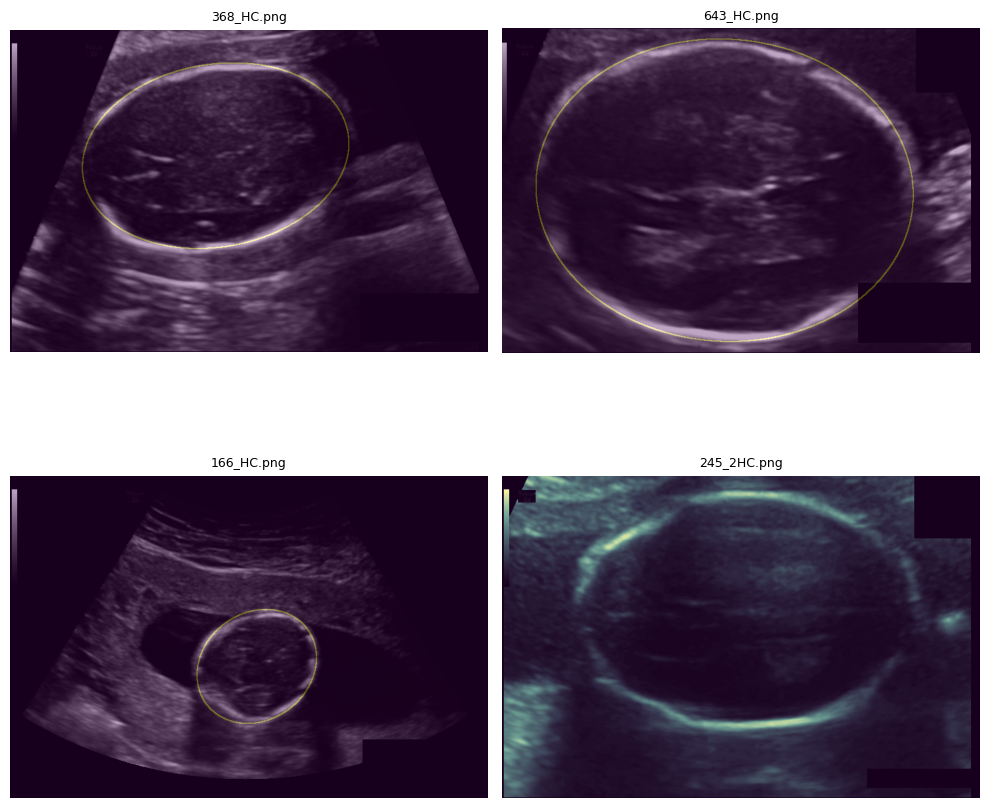

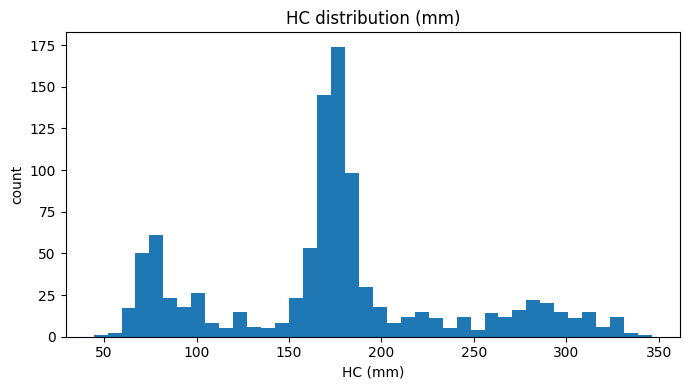

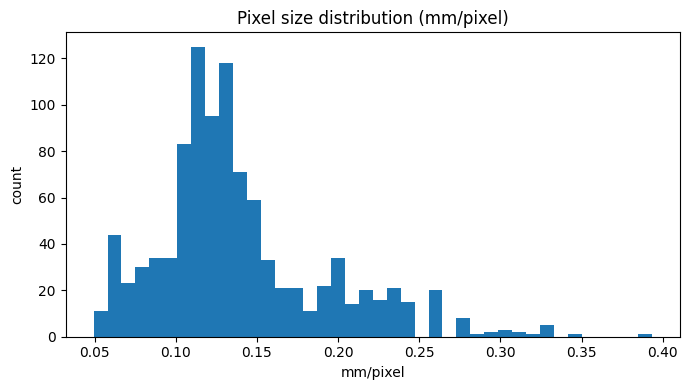

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np

ROOT = Path(r"P:\mlmed2026\Labwork2")
train_csv = ROOT / "training_set_pixel_size_and_HC.csv"
train_dir = ROOT / "training_set"

df = pd.read_csv(train_csv)
df.columns = df.columns.str.strip()

print("Columns:", df.columns.tolist())
print("Rows:", len(df))
print("Unique filenames:", df["filename"].nunique())

print("\nHC (mm) describe:\n", df["head circumference (mm)"].describe())
print("\nPixel size (mm/pixel) describe:\n", df["pixel size(mm)"].describe())

missing_imgs = []
missing_anns = []

for fn in df["filename"].head(50): 
    img_path = train_dir / fn
    ann_path = train_dir / fn.replace("_HC.png", "_HC_Annotation.png")
    if not img_path.exists():
        missing_imgs.append(fn)
    if not ann_path.exists():
        missing_anns.append(fn.replace("_HC.png", "_HC_Annotation.png"))

print("\nMissing image files (first 50 check):", len(missing_imgs))
print("Missing annotation files (first 50 check):", len(missing_anns))

samples = df["filename"].sample(4, random_state=42).tolist()

plt.figure(figsize=(10, 10))
for i, fn in enumerate(samples, 1):
    img_path = train_dir / fn
    ann_path = train_dir / fn.replace("_HC.png", "_HC_Annotation.png")

    img = np.array(Image.open(img_path).convert("L"))
    ann = np.array(Image.open(ann_path).convert("L"))

    plt.subplot(2, 2, i)
    plt.imshow(img, cmap="gray")
    plt.imshow(ann, alpha=0.35)   
    plt.title(fn, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



plt.figure(figsize=(7, 4))
plt.hist(df["head circumference (mm)"], bins=40)
plt.title("HC distribution (mm)")
plt.xlabel("HC (mm)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(df["pixel size(mm)"], bins=40)
plt.title("Pixel size distribution (mm/pixel)")
plt.xlabel("mm/pixel")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [29]:
from pathlib import Path
import pandas as pd

ROOT = Path(r"P:\mlmed2026\Labwork2")

train_csv = ROOT / "training_set_pixel_size_and_HC.csv"
test_csv  = ROOT / "test_set_pixel_size.csv"

df_tr = pd.read_csv(train_csv)
df_te = pd.read_csv(test_csv)

df_tr.columns = df_tr.columns.str.strip()
df_te.columns = df_te.columns.str.strip()

n_train = len(df_tr)
n_test  = len(df_te)

hc_desc = df_tr["head circumference (mm)"].describe()
px_desc = df_tr["pixel size(mm)"].describe()

print(f"Number of training images: {n_train}")
print(f"Number of test images: {n_test}")

print("\nHC (mm):")
print(f"  min={hc_desc['min']:.4f}, max={hc_desc['max']:.4f}, mean={hc_desc['mean']:.4f}, std={hc_desc['std']:.4f}")

print("\nPixel size (mm/pixel):")
print(f"  min={px_desc['min']:.6f}, max={px_desc['max']:.6f}, mean={px_desc['mean']:.6f}, std={px_desc['std']:.6f}")


Number of training images: 999
Number of test images: 335

HC (mm):
  min=44.3000, max=346.4000, mean=174.3831, std=65.2821

Pixel size (mm/pixel):
  min=0.049415, max=0.393280, mean=0.139846, std=0.053005


In [30]:
from pathlib import Path
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torchvision.models as models

# -------------------------
# 0) Config
# -------------------------
ROOT = Path(r"P:\mlmed2026\Labwork2")
TRAIN_DIR = ROOT / "training_set"
TRAIN_CSV = ROOT / "training_set_pixel_size_and_HC.csv"

IMG_SIZE = 256
BATCH_TRAIN = 32
BATCH_VAL = 64
EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 1e-4
SEED = 42

NUM_WORKERS = 0          # ✅ Windows-safe
PIN_MEMORY = torch.cuda.is_available()

# ===== Your training hyperparameters (define these in your script) =====

print("Hyperparameters")
print(f"Input size: {IMG_SIZE}")
print(f"Batch size: {BATCH_TRAIN}")
print(f"Learning rate: {LR}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Epochs: {EPOCHS}")


Hyperparameters
Input size: 256
Batch size: 32
Learning rate: 0.0003
Weight decay: 0.0001
Epochs: 20


In [15]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

In [16]:
def crop_nonblack(img_u8, margin=10, thr=5):
    mask = img_u8 > thr
    ys, xs = np.where(mask)
    if len(xs) == 0:
        return img_u8
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    x1 = max(0, x1 - margin); y1 = max(0, y1 - margin)
    x2 = min(img_u8.shape[1]-1, x2 + margin); y2 = min(img_u8.shape[0]-1, y2 + margin)
    return img_u8[y1:y2+1, x1:x2+1]

@torch.no_grad()
def eval_mae_on_loader(model, loader, device):
    model.eval()
    abs_errs = []
    for x, px, y in loader:
        x, px, y = x.to(device), px.to(device), y.to(device)
        yhat = model(x, px)
        abs_errs.append((yhat - y).abs().detach().cpu().numpy())
    return float(np.mean(np.concatenate(abs_errs)))

In [ ]:
class HC18RegressionDS(Dataset):
    def __init__(self, df, img_dir, img_size=256, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fn = row["filename"]
        px = float(row["pixel size(mm)"])
        y  = float(row["head circumference (mm)"])

        img_path = self.img_dir / fn
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Cannot read image: {img_path}")

        img = crop_nonblack(img)
        img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)

        if self.augment:
            if np.random.rand() < 0.5:
                img = np.fliplr(img).copy()
            if np.random.rand() < 0.5:
                ang = np.random.uniform(-10, 10)
                M = cv2.getRotationMatrix2D((self.img_size/2, self.img_size/2), ang, 1.0)
                img = cv2.warpAffine(img, M, (self.img_size, self.img_size),
                                     flags=cv2.INTER_LINEAR, borderValue=0)

        img = (img.astype(np.float32) / 255.0)[None, ...]  # (1,H,W)
        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor([px], dtype=torch.float32),
            torch.tensor([y], dtype=torch.float32),
        )

In [ ]:
class ResNet18_HCReg(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        w = models.ResNet18_Weights.DEFAULT if pretrained else None
        self.backbone = models.resnet18(weights=w)

        old = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(
            1, old.out_channels,
            kernel_size=old.kernel_size,
            stride=old.stride,
            padding=old.padding,
            bias=False
        )
        if pretrained:
            with torch.no_grad():
                self.backbone.conv1.weight[:] = old.weight.mean(dim=1, keepdim=True)

        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

    
        self.head = nn.Sequential(
            nn.Linear(feat_dim + 1, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x_img, x_px):
        f = self.backbone(x_img)
        z = torch.cat([f, x_px], dim=1)
        return self.head(z)


In [ ]:
df = pd.read_csv(TRAIN_CSV)
df.columns = df.columns.str.strip()

assert "filename" in df.columns, df.columns
assert "pixel size(mm)" in df.columns, df.columns
assert "head circumference (mm)" in df.columns, df.columns

train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)

ds_tr = HC18RegressionDS(train_df, TRAIN_DIR, img_size=IMG_SIZE, augment=True)
ds_va = HC18RegressionDS(val_df,   TRAIN_DIR, img_size=IMG_SIZE, augment=False)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_TRAIN, shuffle=True,
                   num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
dl_va = DataLoader(ds_va, batch_size=BATCH_VAL, shuffle=False,
                   num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = ResNet18_HCReg(pretrained=True).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit = nn.L1Loss()  # MAE loss

train_mae_hist = []
test_mae_hist  = []   # "test" = validation 

best = float("inf")
best_epoch = -1
best_path = ROOT / "best_regressor.pt"

for epoch in range(1, EPOCHS + 1):
    model.train()
    for x, px, y in dl_tr:
        x, px, y = x.to(device), px.to(device), y.to(device)
        opt.zero_grad()
        yhat = model(x, px)
        loss = crit(yhat, y)
        loss.backward()
        opt.step()

    # compute MAE after epoch
    train_mae = eval_mae_on_loader(model, dl_tr, device)
    test_mae  = eval_mae_on_loader(model, dl_va, device)

    train_mae_hist.append(train_mae)
    test_mae_hist.append(test_mae)

    print(f"Epoch {epoch:02d} | Train MAE={train_mae:.3f} mm | Test/Val MAE={test_mae:.3f} mm")

    if test_mae < best:
        best = test_mae
        best_epoch = epoch
        torch.save(model.state_dict(), str(best_path))

print(f"\nBest Test/Val MAE: {best:.3f} mm at epoch {best_epoch}")
print("Saved best model to:", best_path)

Device: cuda
Epoch 01 | Train MAE=145.657 mm | Test/Val MAE=150.369 mm
Epoch 02 | Train MAE=98.325 mm | Test/Val MAE=102.409 mm
Epoch 03 | Train MAE=29.246 mm | Test/Val MAE=30.324 mm
Epoch 04 | Train MAE=25.185 mm | Test/Val MAE=25.085 mm
Epoch 05 | Train MAE=38.265 mm | Test/Val MAE=40.303 mm
Epoch 06 | Train MAE=20.268 mm | Test/Val MAE=20.602 mm
Epoch 07 | Train MAE=11.242 mm | Test/Val MAE=12.362 mm
Epoch 08 | Train MAE=13.917 mm | Test/Val MAE=15.410 mm
Epoch 09 | Train MAE=10.607 mm | Test/Val MAE=13.561 mm
Epoch 10 | Train MAE=22.406 mm | Test/Val MAE=26.430 mm
Epoch 11 | Train MAE=9.808 mm | Test/Val MAE=12.308 mm
Epoch 12 | Train MAE=11.550 mm | Test/Val MAE=13.812 mm
Epoch 13 | Train MAE=13.278 mm | Test/Val MAE=14.505 mm
Epoch 14 | Train MAE=18.515 mm | Test/Val MAE=23.254 mm
Epoch 15 | Train MAE=9.338 mm | Test/Val MAE=12.586 mm
Epoch 16 | Train MAE=9.777 mm | Test/Val MAE=12.914 mm
Epoch 17 | Train MAE=11.166 mm | Test/Val MAE=12.937 mm
Epoch 18 | Train MAE=8.417 mm | Tes

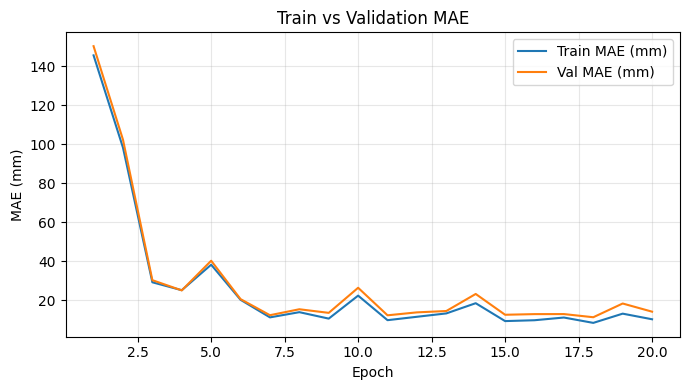

In [25]:
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, train_mae_hist, label="Train MAE (mm)")
plt.plot(epochs, test_mae_hist,  label="Val MAE (mm)")
plt.xlabel("Epoch")
plt.ylabel("MAE (mm)")
plt.title("Train vs Validation MAE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

def run_one_experiment(run_name, img_size, lr, wd, epochs=15):
    ds_tr = HC18RegressionDS(train_df, TRAIN_DIR, img_size=img_size, augment=True)
    ds_va = HC18RegressionDS(val_df,   TRAIN_DIR, img_size=img_size, augment=False)

    dl_tr = DataLoader(ds_tr, batch_size=32, shuffle=True,  num_workers=0, pin_memory=torch.cuda.is_available())
    dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = ResNet18_HCReg(pretrained=True).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit = torch.nn.L1Loss()

    best_val = float("inf")

    for epoch in range(1, epochs+1):
        model.train()
        for x, px, y in dl_tr:
            x, px, y = x.to(device), px.to(device), y.to(device)
            opt.zero_grad()
            yhat = model(x, px)
            loss = crit(yhat, y)
            loss.backward()
            opt.step()

        val_mae = eval_mae_on_loader(model, dl_va, device)
        best_val = min(best_val, val_mae)
        print(f"{run_name} | epoch {epoch:02d} | val_MAE={val_mae:.3f}")

    return best_val

experiments = [
    ("Baseline", 256, 3e-4, 1e-4),
    ("A1",       224, 3e-4, 1e-4),
    ("A2",       256, 1e-4, 1e-4),
    ("A3",       256, 3e-4, 0.0),
]

results = []
for name, img_size, lr, wd in experiments:
    print("\n==============================")
    print(f"Running {name}: img_size={img_size}, lr={lr}, wd={wd}")
    best_val = run_one_experiment(name, img_size, lr, wd, epochs=15)
    results.append((name, img_size, lr, wd, best_val))

print("\n===== Table-ready results =====")
for r in results:
    print(r)



Running Baseline: img_size=256, lr=0.0003, wd=0.0001
Baseline | epoch 01 | val_MAE=162.083
Baseline | epoch 02 | val_MAE=118.478
Baseline | epoch 03 | val_MAE=46.252
Baseline | epoch 04 | val_MAE=33.906
Baseline | epoch 05 | val_MAE=39.812
Baseline | epoch 06 | val_MAE=31.853
Baseline | epoch 07 | val_MAE=14.300
Baseline | epoch 08 | val_MAE=18.095
Baseline | epoch 09 | val_MAE=18.690
Baseline | epoch 10 | val_MAE=18.154
Baseline | epoch 11 | val_MAE=12.866
Baseline | epoch 12 | val_MAE=18.117
Baseline | epoch 13 | val_MAE=11.058
Baseline | epoch 14 | val_MAE=12.449
Baseline | epoch 15 | val_MAE=15.409

Running A1: img_size=224, lr=0.0003, wd=0.0001
A1 | epoch 01 | val_MAE=157.587
A1 | epoch 02 | val_MAE=106.956
A1 | epoch 03 | val_MAE=47.153
A1 | epoch 04 | val_MAE=29.775
A1 | epoch 05 | val_MAE=34.657
A1 | epoch 06 | val_MAE=17.678
A1 | epoch 07 | val_MAE=17.383
A1 | epoch 08 | val_MAE=12.280
A1 | epoch 09 | val_MAE=13.723
A1 | epoch 10 | val_MAE=11.481
A1 | epoch 11 | val_MAE=12.16